# Error Plots for Steady Stokes Flow in Rotating Disk

### Import Stuff

In [1]:
import torch
import torch.nn as nn
import os
import sys
import numpy as np
import math
import scipy.special as bessel
from scipy.io import loadmat

import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300

import matplotlib.pyplot as plt
import cv2

### Load Model and Setup Variables

In [2]:
loadmodel = 'JCPexample1'

imagefilename = 'Error_Plot_' + loadmodel
imagesfolder = "images/"

model = torch.load("savedmodels/" + loadmodel + ".pt").to('cpu')

dim_space = 2
dim_full = dim_space

numpts_r = 10
numpts_th =  60

mu = 1
L = 1  # Length of box the circle/sphere sits inside + Radius of Disk/Sphere
v0 = 1

### Analytic Solution
r,th = torch.meshgrid([torch.linspace(0,1, numpts_r), \
                       torch.linspace(0,2*math.pi, numpts_th)])

x1g = r*torch.cos(th)
x2g = r*torch.sin(th)

xg = torch.stack([x1g.reshape(-1), x2g.reshape(-1)], dim=-1).requires_grad_(True)

integral_factor = 2*math.pi*r.detach().cpu().numpy()/(numpts_r-1)/(numpts_th-1)

u1_true = - v0*r*torch.sin(th)
u2_true = v0*r*torch.cos(th)

u_true = torch.stack([u1_true, u2_true], dim=-1)


ug = model(xg)
ug = ug.reshape([numpts_r, numpts_th, 2])

u1_approx = ug.select(-1, 0).detach().cpu().numpy()
u2_approx = ug.select(-1, 1).detach().cpu().numpy()

x1plot = x1g.detach().cpu().numpy()
x2plot = x2g.detach().cpu().numpy()

u1_plot = u1_true.detach().cpu().numpy()
u2_plot = u2_true.detach().cpu().numpy()

L2_error = np.sqrt( np.sum( ((u1_approx - u1_plot)**2)*integral_factor) \
                   + np.sum( ((u2_approx - u2_plot)**2 )*integral_factor) )
Linf_error = np.max( [np.max( np.abs(u1_approx - u1_plot)) , np.max( np.abs(u2_approx - u2_plot))])

L2_norm_true = np.sqrt( np.sum( ( u1_plot**2)*integral_factor ) \
                       + np.sum( ( u2_plot**2)*integral_factor ) )

Linf_norm_true = np.max( [np.max( np.abs( u1_plot) ), np.max( np.abs( u2_plot))])

print("L2 Error = {:.4f}".format(L2_error))
print("Linf Error = {:.4f}".format(Linf_error))

print('Relative L2 Error = {:.4f}'.format(L2_error/L2_norm_true))
print('Relative Linf Error = {:.4f}'.format(Linf_error/Linf_norm_true))

L2 Error = 0.0161
Linf Error = 0.0164
Relative L2 Error = 0.0115
Relative Linf Error = 0.0164


### Plotting

[Text(0, -1.0, ''),
 Text(0, -0.5, ''),
 Text(0, 0.0, ''),
 Text(0, 0.5, ''),
 Text(0, 1.0, '')]

<Figure size 5400x3600 with 0 Axes>

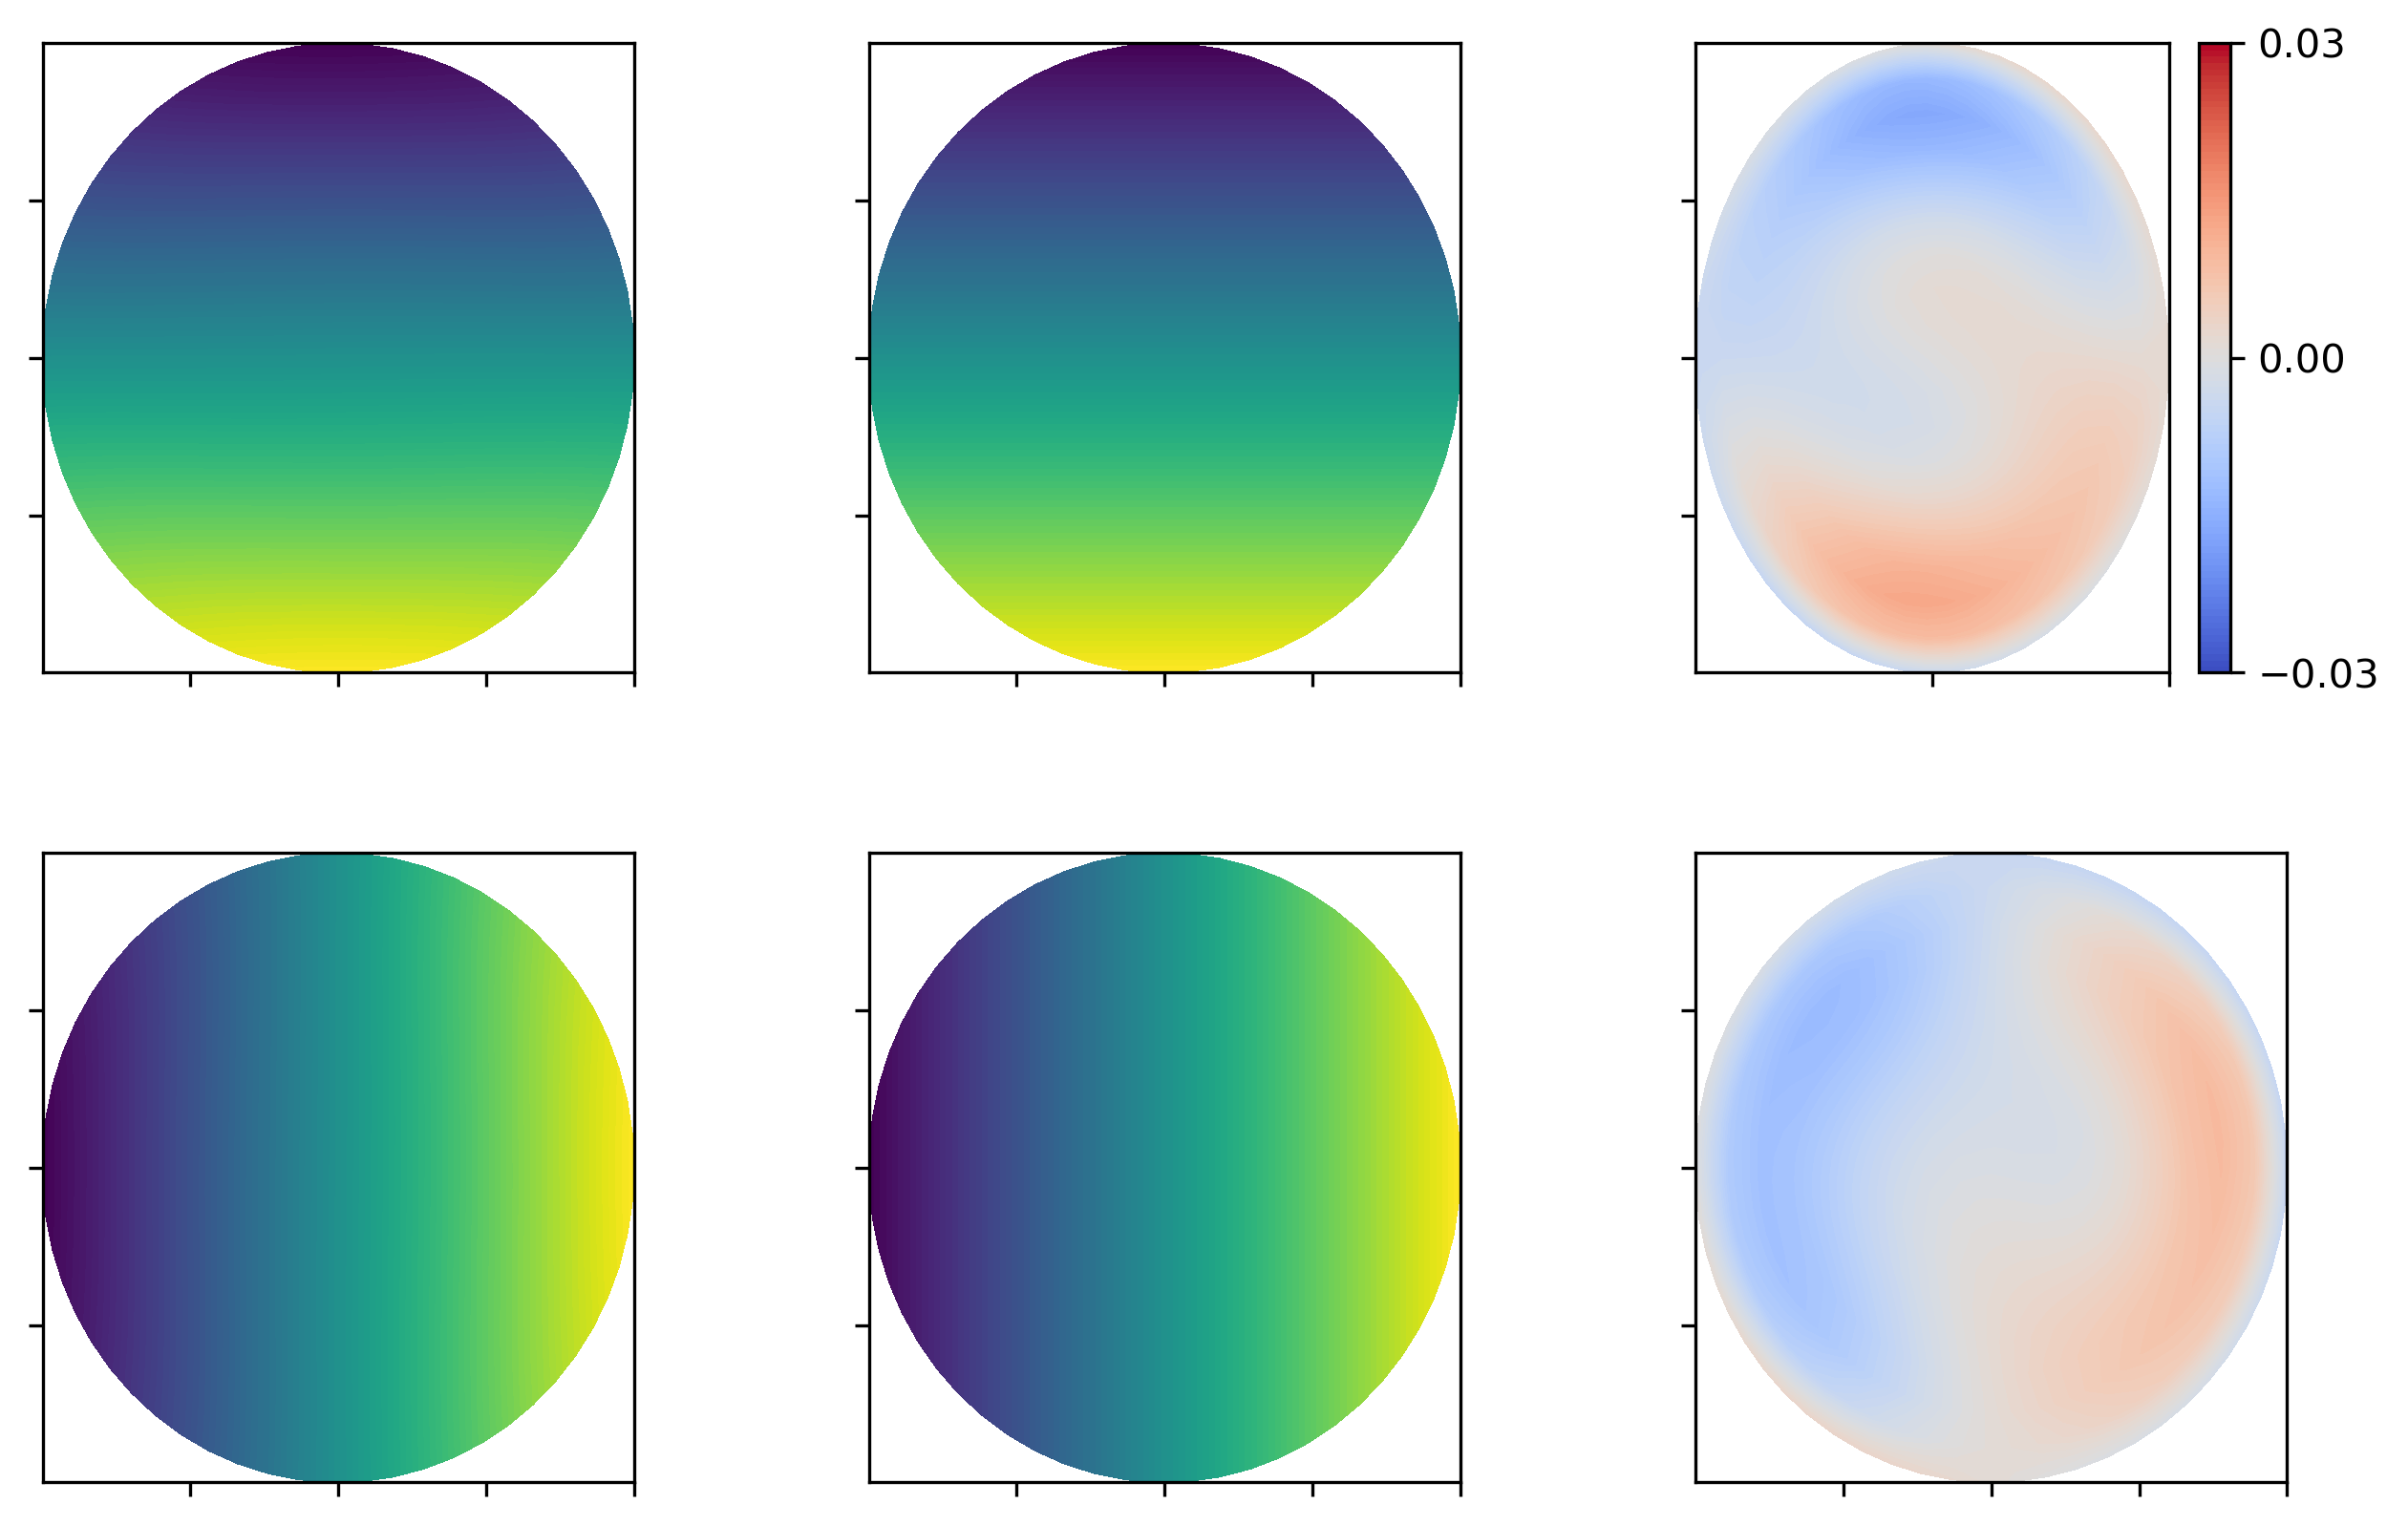

In [3]:

levels_stokes_flow = np.linspace(-1.0, 1.0, 100)
ticks_stokes_flow  = np.linspace(-1.0, 1.0, 3)

levels_error = np.linspace(-0.02, 0.02, 100)
ticks_error = np.linspace(-0.02, 0.02, 3)

fig = plt.figure(figsize=(18,12))
#fig.suptitle('Learning Steady Stokes FLow in Rotating Disk' )

fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize=(9,6))
fig.tight_layout(pad=2.5)

contour0 = ax[0,0].contourf(x1plot, x2plot, u1_approx, levels = levels_stokes_flow,
                             cmap=plt.cm.viridis)

#ax[0,0].set_title("NN Approximation of u1 velocity")
ax[0,0].set_xticklabels([])
ax[0,0].set_yticklabels([])
#plt.colorbar(contour0, ticks =ticks_stokes_flow, ax=ax[0,0])


contour1 = ax[0,1].contourf(x1plot, x2plot, u1_plot, levels = levels_stokes_flow,
                 cmap=plt.cm.viridis)
#ax[0,1].set_title("Analytic Solution of u1 velocity")
ax[0,1].set_xticklabels([])
ax[0,1].set_yticklabels([])
#plt.colorbar(contour1, ticks =ticks_stokes_flow, ax=ax[0,1])

contour2 = ax[0,2].contourf(x1plot, x2plot, u1_approx - u1_plot, 
                            levels = levels_error, cmap=plt.cm.coolwarm)
#ax[0,2].set_title("Difference of approx and true u1 velocity")
ax[0,2].set_xticklabels([])
ax[0,2].set_yticklabels([])
plt.colorbar(contour2, ticks = ticks_error, ax=ax[0,2])

contour3 = ax[1,0].contourf(x1plot, x2plot, u2_approx, levels = levels_stokes_flow,
                 cmap=plt.cm.viridis)
#ax[1,0].set_title("NN Approximation of u2 velocity")
ax[1,0].set_xticklabels([])
ax[1,0].set_yticklabels([])
#plt.colorbar(contour3, ticks =ticks_stokes_flow, ax=ax[1,0])

contour4 = ax[1,1].contourf(x1plot, x2plot, u2_plot, levels = levels_stokes_flow,
                             cmap=plt.cm.viridis)
#ax[1,1].set_title("Analytic Solution of u2 velocity")
#ax[1,1].set_xlabel(r'$x_1$')
#ax[1,1].set_ylabel(r'$x_2$')
ax[1,1].set_xticklabels([])
ax[1,1].set_yticklabels([])
#plt.colorbar(contour4, ticks =ticks_stokes_flow, ax=ax[1,1])

contour5 = ax[1,2].contourf(x1plot, x2plot, u2_approx - u2_plot, levels = levels_error,
                            cmap=plt.cm.coolwarm)
#ax[1,2].set_title("Difference of approx and true u2 velocity")
#ax[1,2].set_xlabel(r'$x_1$')
#ax[1,2].set_ylabel(r'$x_2$')
ax[1,2].set_xticklabels([])
ax[1,2].set_yticklabels([])
#plt.colorbar(contour5, ticks =ticks_error, ax=ax[1,2])
